In [2]:
import numpy as np 
import os 
import cv2  
import pandas as pd 
from tqdm import tqdm 
from random import shuffle 

In [3]:
LR = 0.003
MODEL_NAME = 'plantclassfication-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which save

In [4]:
train_dir="F:/python/ML/Anaconda/tensorflow_env123/seedlings-classification/train"
test_dir="F:/python/ML/Anaconda/tensorflow_env123/seedlings-classification/test"

In [5]:
IMG_SIZE = 128

In [6]:
def label_img(word_label):                       
    if word_label == 'Black-grass': return [1,0,0,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Charlock': return [0,1,0,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Cleavers': return [0,0,1,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Common Chickweed': return [0,0,0,1,0,0,0,0,0,0,0,0]
    elif word_label == 'Common wheat': return [0,0,0,0,1,0,0,0,0,0,0,0]
    elif word_label == 'Fat Hen': return [0,0,0,0,0,1,0,0,0,0,0,0]
    elif word_label == 'Loose Silky-bent': return [0,0,0,0,0,0,1,0,0,0,0,0]
    elif word_label == 'Maize': return [0,0,0,0,0,0,0,1,0,0,0,0]
    elif word_label == 'Scentless Mayweed': return [0,0,0,0,0,0,0,0,1,0,0,0]
    elif word_label == 'Shepherds Purse': return [0,0,0,0,0,0,0,0,0,1,0,0]
    elif word_label == 'Small-flowered Cranesbill': return [0,0,0,0,0,0,0,0,0,0,1,0]
    elif word_label == 'Sugar beet': return [0,0,0,0,0,0,0,0,0,0,0,1] 


In [ ]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)
print (NUM_CATEGORIES)

In [ ]:
def create_train_data():
    train = []
    for category_id, category in enumerate(CATEGORIES):
        for img in tqdm(os.listdir(os.path.join(train_dir, category))):
            label=label_img(category)
            path=os.path.join(train_dir,category,img)
            img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            train.append([np.array(img),np.array(label)])
    shuffle(train)
    np.save('train_data.npy', train)
    return train

In [8]:
train_data = np.load('train_data.npy')

In [9]:
def create_test_data():
    test = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir,img)
        img_num = img
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        test.append([np.array(img), img_num])
        
    shuffle(test)
    return test

In [10]:
import tensorflow as tf #used for machine learning applications such as neural networks
import tflearn #modular and transparent deep learning library built on top of Tensorflow
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
tf.reset_default_graph()


In [11]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 12, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


In [12]:
model = tflearn.DNN(convnet, tensorboard_dir='log')

In [13]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')


In [14]:
train = train_data
test = train_data


In [15]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


In [25]:
print(X.shape)

print(test_x.shape)


(4750, 128, 128, 1)
(4750, 128, 128, 1)


In [16]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [17]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\USER\tensorflow_env\kaggle projects\plantclassfication-0.003-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [18]:
#return Indexes of the maximal elements of a array
def label_return (model_out):
    if np.argmax(model_out) == 0: return  'Black-grass'
    elif np.argmax(model_out) == 1: return 'Charlock'
    elif np.argmax(model_out) == 2: return 'Cleavers'
    elif np.argmax(model_out) == 3: return 'Common Chickweed'
    elif np.argmax(model_out) == 4: return 'Common wheat'
    elif np.argmax(model_out) == 5: return 'Fat Hen'
    elif np.argmax(model_out) == 6: return 'Loose Silky-bent'
    elif np.argmax(model_out) == 7: return 'Maize'
    elif np.argmax(model_out) == 8: return 'Scentless Mayweed'
    elif np.argmax(model_out) == 9: return 'Shepherds Purse'
    elif np.argmax(model_out) == 10: return 'Small-flowered Cranesbill'
    elif np.argmax(model_out) == 11: return 'Sugar beet'
    

In [19]:
import matplotlib.pyplot as plt

test_data = create_test_data()


100%|██████████| 794/794 [00:24<00:00, 32.87it/s]


<Figure size 1800x1000 with 12 Axes>

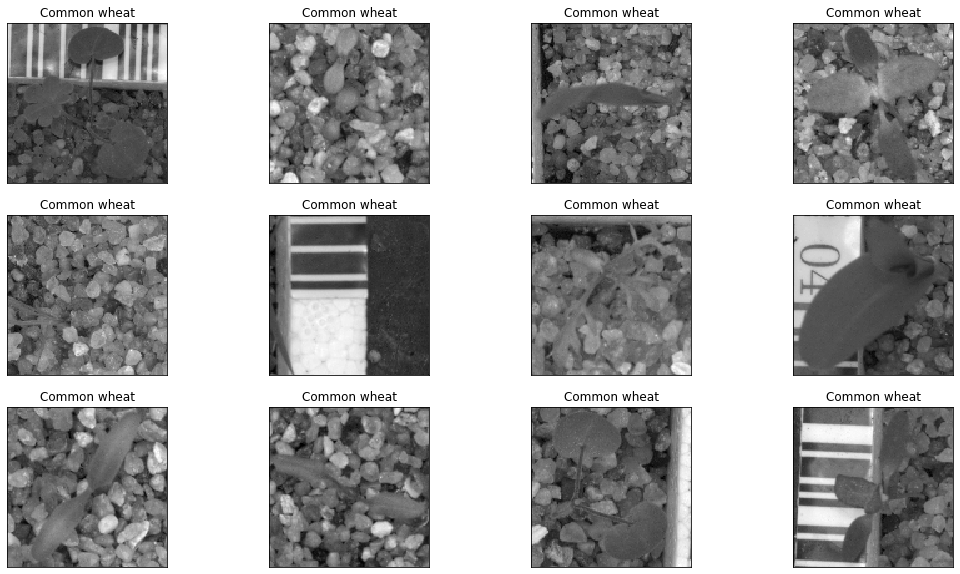

In [21]:
fig=plt.figure(figsize = (18,10))
for num,data in enumerate(test_data[:12]): 
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    str_label=label_return (model_out)
    y.imshow(orig,cmap='gray',interpolation='nearest')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()